In [3]:
# ============================================================
# Machine Learning Project — Client Retention Prediction
# Full Notebook: EDA + Feature Engineering + ML + SHAP + Export
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, average_precision_score
)

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)


In [4]:
df = pd.read_excel("data.xlsx", parse_dates=["Date"])

# Clean
df = df.dropna(subset=["Customer_ID", "Date", "Purchase_Value"])
df["Purchase_Value"] = df["Purchase_Value"].astype(float)

df["Return_Visit"] = df["Return_Visit"].map({"Yes": 1, "No": 0})
df["Discount_Used"] = df["Discount_Used"].map({"Yes": 1, "No": 0})
df["Email_Engagement"] = df["Email_Engagement"].map(
    {"Ignored": 0, "Opened": 1, "Clicked": 2}
)


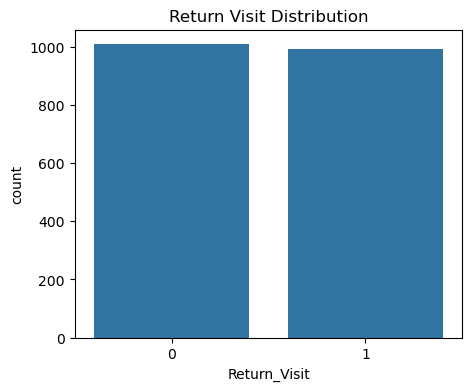

In [5]:
plt.figure(figsize=(5,4))
sns.countplot(x=df["Return_Visit"])
plt.title("Return Visit Distribution")
plt.savefig("eda_return_rate.png", dpi=300)
plt.show()


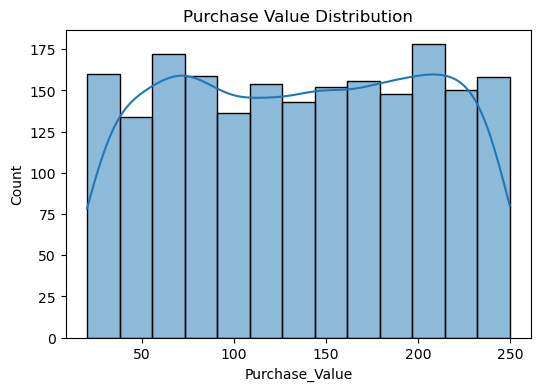

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(df["Purchase_Value"], kde=True)
plt.title("Purchase Value Distribution")
plt.savefig("eda_purchase_value.png", dpi=300)
plt.show()


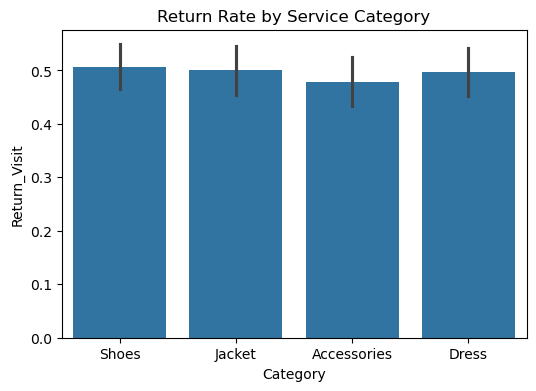

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Category", y="Return_Visit")
plt.title("Return Rate by Service Category")
plt.savefig("eda_return_by_category.png", dpi=300)
plt.show()


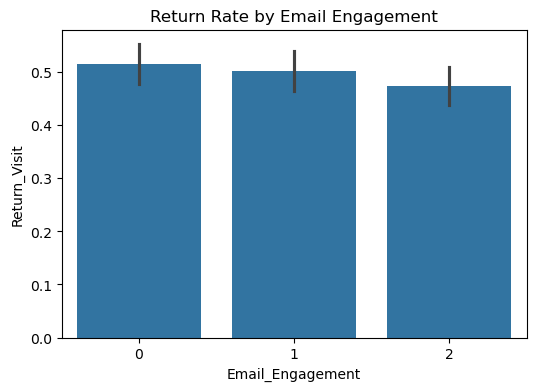

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Email_Engagement", y="Return_Visit")
plt.title("Return Rate by Email Engagement")
plt.savefig("eda_email_effect.png", dpi=300)
plt.show()


In [9]:
# RFM
rfm = df.groupby("Customer_ID").agg(
    last_purchase=("Date", "max"),
    frequency=("Date", "count"),
    total_spent=("Purchase_Value", "sum"),
    avg_spent=("Purchase_Value", "mean")
).reset_index()

ref_date = df["Date"].max()
rfm["recency_days"] = (ref_date - rfm["last_purchase"]).dt.days

# merge with latest record
latest = df.sort_values("Date").drop_duplicates("Customer_ID", keep="last")
df_final = latest.merge(rfm, on="Customer_ID", how="left")

# time features
df_final["purchase_month"] = df_final["Date"].dt.month
df_final["purchase_dayofweek"] = df_final["Date"].dt.dayofweek

# One-hot encoding
df_final = pd.get_dummies(df_final, columns=["Category"], drop_first=True)


In [10]:
target = "Return_Visit"
features = [
    "Purchase_Value", "Email_Engagement", "Discount_Used",
    "frequency", "total_spent", "avg_spent", "recency_days",
    "purchase_month", "purchase_dayofweek"
] + [c for c in df_final.columns if c.startswith("Category_")]

X = df_final[features]
y = df_final[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

model = XGBClassifier(
    n_estimators=350,
    max_depth=6,
    learning_rate=0.05,
    colsample_bytree=0.9,
    subsample=0.9,
    eval_metric="logloss"
)

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)


In [11]:
print("Accuracy =", accuracy_score(y_test, preds))
print("F1 =", f1_score(y_test, preds))
print("Precision =", precision_score(y_test, preds))
print("Recall =", recall_score(y_test, preds))
print("ROC AUC =", roc_auc_score(y_test, probs))
print("PR AUC =", average_precision_score(y_test, probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Accuracy = 0.462
F1 = 0.5417376490630323
Precision = 0.44662921348314605
Recall = 0.6883116883116883
ROC AUC = 0.46544038365599705
PR AUC = 0.4446062459519231
Confusion Matrix:
 [[ 72 197]
 [ 72 159]]


In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, show=False)
plt.savefig("shap_summary.png", dpi=300)
plt.close()

print("SHAP saved.")


SHAP saved.


In [13]:
joblib.dump(model, "retention_model.pkl")
df_final.to_csv("prepared.csv", index=False)

print("Export complete.")


Export complete.
